# Function Calling
**Function calling** enables us to connect LLMs to external data and systems. 
We can define a set of functions as tools that the model has access to, and it can use them when appropriate based on the conversation history. We can then execute those functions on the **application** side, and provide the results back to the model. 

## How Function Calling Works
"Function calling" naming is confusing. LLMs don't actually call any functions themselves; they suggest which functions you should call from  pre-defined functions which you provide to the LLM in a prompt. Function calling is a type of structured ouput capability of a LLM. Yet, strctured output enables us to intergate LLMs with classical software systems.

When you use function calling, the model never actually executes functions itself, instead it simply generates parameters that can be used to call our function.

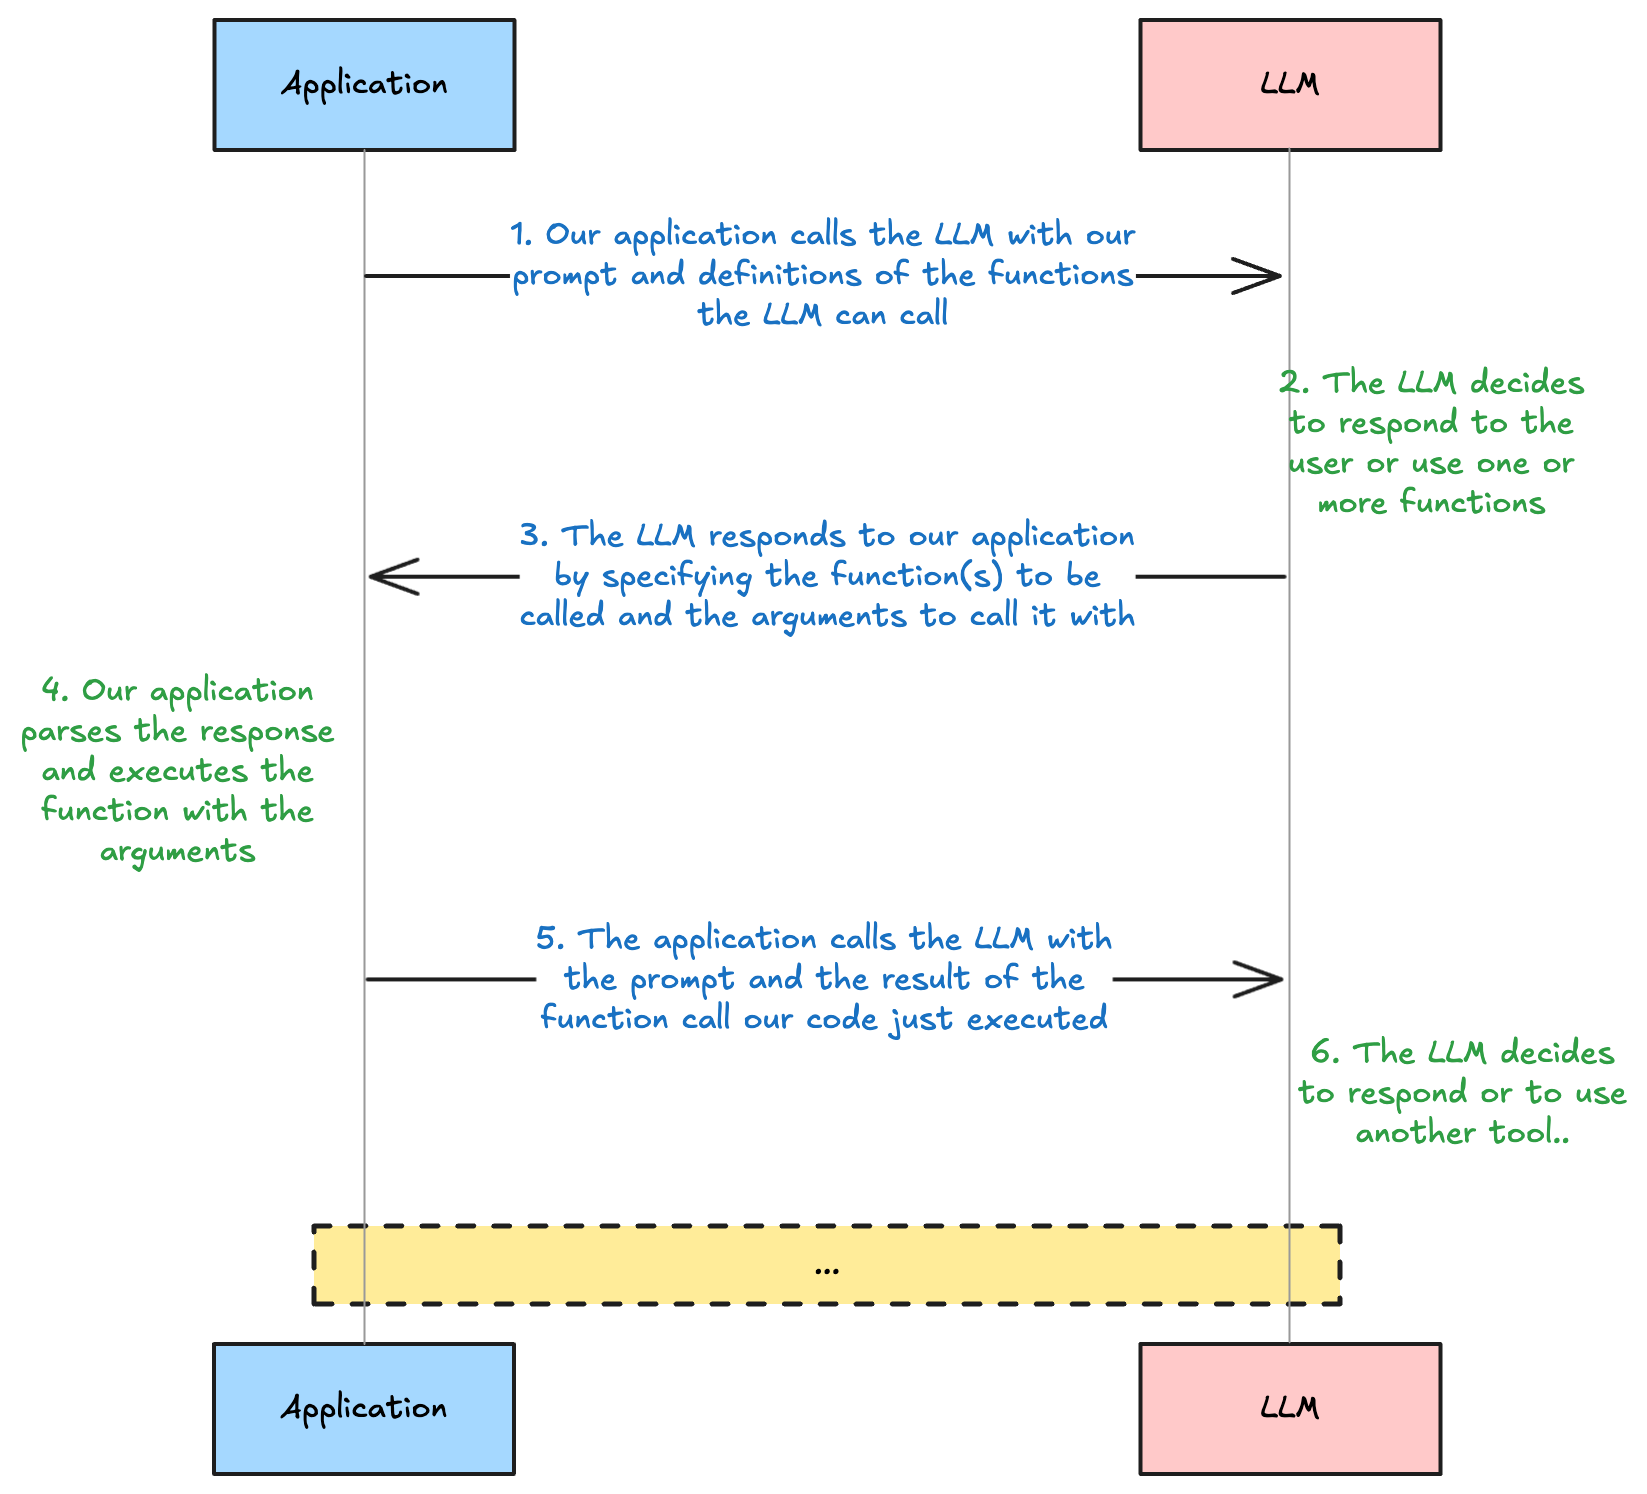

The starting point for function calling is choosing a function in your own codebase that you'd like to enable the model to generate arguments for. 

### Handling model responses
The model only suggests function calls and generates arguments for the defined functions when appropriate. It is then up to us to decide how our application handles the execution of these suggestions. 

If the model determines that a function should be called, it will return a `tool_calls` field in the response, which we can use to determine if the model generated a function call and what the argumets were.

#### Warning
Before diving any deeper, remember, all an LLM does it next token prediction. Due to the principle LLM architecture all it can possibly output is one token with the highes probability. In documentation OpenAI refers to function calling as a capability. Function calling capability is achieved via fine-tuning of a model, when enables it to output data in a specific way. To oversimplify, a structured-output-capable model was just trained on more JSON. Therefore, function calling is merely JSON structured output which contains the name of a function to call and parameters for it.

#### Why do we care about function calling?
Three main reasons:
1. **Models don't have all the data**. Models acquire their "knowledge" during the training process, and that "knowlege" is stored in the model's weights, we cannot be easily updated on demand. To update "knowlege" you effectively need to update the model's weights and run all the post-training routines.

2. **Models need to be integrated with other systems**. Strcutured output capability enables output to be integrated with other parts of the system via JSON. We can even treat strctured output-enabled LLM as some sort of API which returns JSON. There is a world of difference between: 

```
Hi, my name is Hanan Ather, I'm 27, and my email is hanan@example.com

```
and 
```
{
    "name": "Hanan Ather",
    "age": 27,
    "email": "hanan@example.com"
}

```
Strcutured output not only make integrations simpler, but they easily enable tasks which normally required eloborated NLP systems. 


Many applications require models to call custom functions to trigger actions within the application or interact with external systems.

- Fetching data: enable a conversational assistant to retrieve databased on conversation, like scheduling meetings or initiating order systems
- Taking action: allowing a assistant to trigger actions based on the conversation, like scheduling meetings or initiating order returns
- Building workflows: allow assistants to execute multi-step workflows, like data extraction pipelines or content personalization

## Structured Output
Strcutured output is a models capability to output JSON, acquired during fine-tuning. 

**Use case of strcutured output:**
- implement a natural langugage processing parser that allows users to create grocery lists out of natural langauge input. The use provides a list of groceries in written or spoken form, and the program outputs an HTML-formatted list.

  - Without LLMs, this is not such an easy task to tackle. Its easy to build a demo, but not easy to build-high quality prodcut that handles edge cases well. 

- Today we can accomplish this by: pipe user input into the LLM -> LLM outputs JSON -> Python picks it up and formats the JSON into HTML



In [5]:
# Further down these imports will be ommited for brevity
import os
from openai import OpenAI
from openai.types.chat import ChatCompletion  # Add this import


def eval(prompt: str, message: str, model: str = "gpt-4o") -> ChatCompletion:
    client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])
    messages = [
        {"role": "system", "content": prompt},
        {"role": "user", "content": message},
    ]

    return client.chat.completions.create(
        model=model,
        messages=messages
    )

In [6]:
prompt = """
You are a data parsing assistant. 
User provides a list of groceries. 
Your goal is to output it as JSON.
"""
message = "I'd like to buy some bread, pack of eggs, few apples, and a bottle of milk."

res = eval(prompt=prompt, message=message)
json_data = res.choices[0].message.content

print(json_data)

```json
{
  "groceries": [
    "bread",
    "pack of eggs",
    "few apples",
    "bottle of milk"
  ]
}
```


We can see that the model didn't return JSON, it returned markdown formated string containing JSON. The reason is that we didn't enable strcutured output in the API call.

In [11]:
def eval(prompt: str, message: str, model: str = "gpt-4o") -> ChatCompletion:
    client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])
    messages = [
        {"role": "system", "content": prompt},
        {"role": "user", "content": message},
    ]

    return client.chat.completions.create(
        model=model,
        messages=messages,
        # Enable strctured output
        response_format={"type": "json_object"},
    )

In [12]:
prompt = """
You are a data parsing assistant. 
User provides a list of groceries. 
Your goal is to output it as JSON.
"""
message = "I'd like to buy some bread, pack of eggs, few apples, and a bottle of milk."

res = eval(prompt=prompt, message=message)
json_data = res.choices[0].message.content

print(json_data)

{
    "groceries": [
        {
            "item": "bread",
            "quantity": 1
        },
        {
            "item": "pack of eggs",
            "quantity": 1
        },
        {
            "item": "apples",
            "quantity": "few"
        },
        {
            "item": "bottle of milk",
            "quantity": 1
        }
    ]
}


Now, running the same code returns plain JSON. This is not only great because we don't need to parse anything extra but, but it also guarantees that the LLM won't include any free-from text such as "Sure, here is your data!{}"

The problem is, we don't have the data shaped defined; lets call it *schema*. Our schema is now up to the LLM, and it might change based on user input. Lets rephrase the user query to see it in action.  Instead of asking, “I’d like to buy some bread, a pack of eggs, a few apples, and a bottle of milk,” let’s ask, “12 eggs, 2 bottles of milk, 6 sparkling waters.”

In [14]:
message = "12 eggs, 2 bottles of milk, 6 sparkling waters"
res = eval(prompt=prompt, message=message)

json_data = res.choices[0].message.content
print(json_data)

{
  "groceries": [
    {
      "item": "eggs",
      "quantity": 12,
      "unit": "pieces"
    },
    {
      "item": "milk",
      "quantity": 2,
      "unit": "bottles"
    },
    {
      "item": "sparkling waters",
      "quantity": 6,
      "unit": "bottles"
    }
  ]
}


Strcutured output not only enables JSON ouput, it also helps with schema. The way we can state and define schema is via prompt engineering. 

In [15]:
prompt = """
You are data parsing assistant. 
User provides a list of groceries. 
Use the following JSON schema to generate your response:

{{
    "groceries": [
        { "name": ITEM_NAME, "quantity": ITEM_QUANTITY }
    ]
}}

Name is any string, quantity is a numerical value.
"""

inputs = [
    "I'd like to buy some bread, pack of eggs, few apples, and a bottle of milk.",
    "12 eggs, 2 bottles of milk, 6 sparkling waters.",
]

for message in inputs:
    res = eval(prompt=prompt, message=message)
    json_data = res.choices[0].message.content
    print(json_data)

{
    "groceries": [
        { "name": "bread", "quantity": 1 },
        { "name": "pack of eggs", "quantity": 1 },
        { "name": "apples", "quantity": 3 },
        { "name": "bottle of milk", "quantity": 1 }
    ]
}
{
    "groceries": [
        { "name": "eggs", "quantity": 12 },
        { "name": "bottles of milk", "quantity": 2 },
        { "name": "sparkling waters", "quantity": 6 }
    ]
}


## Serialization
Usually, JSON ouput won't cut it in software systems. Its just a string after all. We have to ensure that the LLM indeed returns correctly formed data. 

In [38]:
from typing import TypeVar, List, Self, Any, Generic, Callable, Optional
from dataclasses import dataclass
import json
from pprint import pprint as pp

T = TypeVar("T")

# Immutable grocery item container
@dataclass(frozen=True)
class Item:
    name: str
    quantity: int

# Immutable groceries container
@dataclass(frozen=True)
class Groceries:
    groceries: List[Item]

    @staticmethod
    def serialize(data: Any) -> Self:
        """JSON serialization function."""
        json_data = json.loads(data) # Converts JSON string to Python dict
        items = [Item(**item) for item in json_data["groceries"]] # Creates Item objects

        return Groceries(groceries=items)


# Edited `eval` function to handle types and serialization
def eval(
    prompt: str,
    message: str,
    schema: Generic[T],
    serializer: Callable = None,
    model: str = "gpt-4o",
    client: OpenAI = OpenAI(api_key=os.environ["OPENAI_API_KEY"]),
) -> Optional[T]:
    messages = [
        {"role": "system", "content": prompt},
        {"role": "user", "content": message},
    ]

    completion = client.chat.completions.create(
        model=model,
        response_format={"type": "json_object"},
        messages=messages,
    )

    try:
        completion_data = completion.choices[0].message.content
        json_data = json.loads(completion_data)

        if serializer is not None:
            return serializer(completion_data)
        else:
            return schema(**json_data)
    except TypeError as type_error:
        # Happens when dictionary data shape doesn't match provided schema layout.
        return None
    except json.JSONDecodeError as json_error:
        # Happens when LLM outputs incorrect JSON, or ``json`` module fails
        # to parse it for some other reason.
        return None

1. First we declare a type variable which will be used to pass schema class as a parameter.
2. Then we describe our JSON data using the data class
3. `Gorceries` has `serialize` defined on it to parse nested JSON correctly. Our `eval` function is in principle the same as before. It gets a `schema` and an optional `serializer` for data serialization. 

In [39]:
res = eval(
    prompt=prompt,
    message="I'd like to buy some bread, pack of eggs, few apples, and a bottle of milk.",
    schema=Groceries,
    serializer=Groceries.serialize,
)
# Pretty print it
pp(res)

Groceries(groceries=[Item(name='bread', quantity=1),
                     Item(name='pack of eggs', quantity=1),
                     Item(name='apples', quantity=3),
                     Item(name='bottle of milk', quantity=1)])


## Strcutured Extraction
Function calling can be used to extract structured data from natural language input. 
Structured extraction is fundamentally about mapping unstructured text $\to$ structured data. Think of it as specialized form of feature engineering, but instead of transforming existing structured data, we're extracting it from text. 

---
### Dataclasses 
Think of a [dataclass](https://docs.python.org/3/library/dataclasses.html) as a blueprint for storing related pieces of information together, with a lot of features automatically added. Its like a smart container that knows how to handle its contents properly.

The key benefits of `dataclasses` are 
1. reduces repetitive code for data-holding classes
2. enforces type saftey through annotations
3. handle common operations (equality testing, string representation, etc.)

They are useful when our class is primarly about storing data rather than behavior and we want immutable data structures. They provide clear type definitions for our data and automatically generate common methods (`__init__`,`__repr__`, `__eq__`). 

We use the dataclass as a schema to identify what fields to extract and validate the data matches expected formats
- postal code follows A1A 1A1 pattern
- province is valid two-letter
- required fields are present

The dataclass ensures our extracted data is:
- complete (all required fields present)
- correctly typed
- validated


---
Structured extraction is about converting messy text into clean structured data. **The key idea is to use LLMs as our pattern recognition engine, turning unstructured text into structured JSON that matches our schema.**
Think of the LLM as a smart pattern recognizer that can understand context and variations in how people write addresses. It's more flexible than regex patterns but needs the structure of our dataclasses to ensure reliable output.

---
The "structured" part needs to be precisely defined - what fields do we want to extract, what types should they be, how should they be validated? This is where dataclasses shine:
1. Define the structure you want to extract using dataclasses
2. Use this structure as both a schema and a container for the extracted data
3. Validate and process the extracted data
---

## Example: Extracting Addresses
A common real-world application is extracting business addresses from unstructured text (like web pages, documents, or databases) into a standardized format. Here's how we'd use dataclasses for this:


### Schema Definition
The schema is our contract with the data. It's where we say "this is exactly what we want to get out of our text". Using dataclasses makes this contract explicit and enforceable. Think of it like a form where every field has a specific purpose and type.

Here's what a schema typically defines:
1. What fields we want to extract (name, address, etc.)
2. What type each field should be (string, number, etc.)
3. Which fields are required vs optional
4. Any special formats or patterns fields should follow

We use dataclasses to define what data we want:

``` python
@dataclass(frozen=True)
class Address:
    name: str
    street_number: str
    street_name: str
    city: str
```

### Serialization
We need to convert between JSON and our dataclasses. The `serialize` method handles this conversion:

```python
@staticmethod
def serialize(data: Any) -> Self:
    json_data = json.loads(data)  # JSON string → Python dict
    addresses = [Address(**addr)]  # dict → Address objects
    return AddressBook(addresses=addresses)
```
### LLM Integration

The `eval` function is our bridge to the LLM. It has three main jobs: 
1. Format our prompt and input for the LLM
2. Get structured JSON back
3. Convert that JSON into our dataclass objects

### Error Prevention
The system can fail in several ways:
- LLM returns malformed JSON
- JSON doesn't match our schema
- Data fails validation
We handle these with:

``` python
try:
    completion_data = completion.choices[0].message.content
    json_data = json.loads(completion_data)
    return serializer(completion_data)
except TypeError:
    # Schema mismatch
except json.JSONDecodeError:
    # Bad JSON
```
#### Type Safety
We use `Generic[T]` to make our function type-safe. We can think of generics like a template or a placeholder for a type that will be specified later. It's like having a box and saying "this box will hold something, but I'll tell you what it holds when I actually use it".

```Python
T = TypeVar("T")

def eval(
    prompt: str, 
    message: str,
    schema: Generic[T],  # This is our "template" - could be Address, Groceries, etc.
) -> Optional[T]:       # We'll return that same type (or None)
    # ... LLM processing ...
    return schema(**json_data)
    
# Usage examples:
address = eval(prompt, message, schema=Address)
# Python knows address is an Address object

groceries = eval(prompt, message, schema=Groceries)
# Python knows groceries is a Groceries object
```

We're using generics to create a flexible but type-safe function that can work with any dataclass schema.
- **Type Safety**: If you try to use `address.items` when address is an `Address` object, Python will catch this error before you run the code
- **Code Reuse**: The same eval function works for any schema you define
- **IDE Support**: Your IDE can provide correct autocomplete because it knows what type you're working with

Without generics, we'd either need separate functions for each type (`eval_address`, `eval_groceries`, etc.) or a function that returns `Any`, losing all type information



#### Optional and Hierarchical Fields

We can also enhance the Address structure to handle optional fields and hierarchical relationships. Here's how:

``` python
@dataclass(frozen=True)
class ResidentialUnit:
    unit_number: str
    floor: Optional[str] = None

@dataclass(frozen=True)
class Address:
    # Required fields
    street_number: str
    street_name: str
    city: str
    
    # Optional fields
    name: Optional[str] = None
    postal_code: Optional[str] = None
    
    # Hierarchical - only for apartments/units
    unit: Optional[ResidentialUnit] = None
```

We are using `Optional` for fields that might not exist. We can create nested structures for related fields (like unit details), set sensible defaults where appropriate and use inheritance for different types of addresses if needed. 

#### The Serialization Process
Let's break down how the JSON-to-object conversion works. When the LLM returns JSON, it looks like this:
``` python
json_string = """
{
    "addresses": [
        {
            "name": "Hanan Ather",
            "street_number": "123",
            "street_name": "Elm St",
            "city": "Ottawa"
        },
        {
            "name": "Serge Godbout",
            "street_number": "456",
            "street_name": "Oak Ave",
            "city": "Gatineau"
        }
    ]
}
"""
```
`json.loads` converts this string to a Python dictionary:
```python
{
    "addresses": [
        {"name": "Hanan Ather", ...},
        {"name": "Serge Godbout", ...}
    ]
}
```



In [46]:
from typing import TypeVar, List, Self, Any, Generic, Callable, Optional
from dataclasses import dataclass
import json
from pprint import pprint as pp

T = TypeVar("T")

@dataclass(frozen=True)
class Address:
    name: str
    street_number: str
    street_name: str
    city: str

@dataclass(frozen=True)
class Addresses:
    addresses: List[Address]
    
    @staticmethod
    def serialize(data: Any) -> Self:
        """Convert JSON to Addresses instance.
        
        [Address(**addr) for addr in json_data["addresses"]] is:
        1. Getting the list of address dictionaries with json_data["addresses"]
        2. For each dictionary, unpacking it into the Address constructor with **addr
        3. Creating a list of Address objects
        """
        json_data = json.loads(data)
        addresses = [Address(**addr) for addr in json_data["addresses"]]
        return Addresses(addresses=addresses)


def eval(
    prompt: str,
    message: str,
    schema: Generic[T],
    serializer: Callable = None,
    model: str = "gpt-4o",
    client: OpenAI = OpenAI(api_key=os.environ["OPENAI_API_KEY"]),
) -> Optional[T]:
    messages = [
        {"role": "system", "content": prompt},
        {"role": "user", "content": message},
    ]

    completion = client.chat.completions.create(
        model=model,
        response_format={"type": "json_object"},
        messages=messages,
    )

    try:
        completion_data = completion.choices[0].message.content
        json_data = json.loads(completion_data)

        if serializer is not None:
            return serializer(completion_data)
        else:
            return schema(**json_data)
    except TypeError as type_error:
        # Happens when dictionary data shape doesn't match provided schema layout.
        return None
    except json.JSONDecodeError as json_error:
        # Happens when LLM outputs incorrect JSON, or ``json`` module fails
        # to parse it for some other reason.
        return None


text = """
The Ottawa Public Library is at 150 Elgin Street, Ottawa.
Down the street, Sarah Wilson runs her bakery at 240 Laurier Avenue, Ottawa.
Over in Kanata, Tech Corp's office is at 1385 Terry Fox Drive.
"""

prompt = """
You are address parsing assistant. 
User provides text containing addresses.
Extract addresses from the text.
Use the following JSON schema to generate your response:


Format as JSON matching this example:
{
    "addresses": [
        {
            "name": PERSON_OR_BUSINESS_NAME,
            "street_number": BUILDING_NUMBER,
            "street_name": STREET_NAME,
            "city": CITY_NAME
        }
    ]
}

"""



res = eval(
    prompt=prompt,
    message= text,
    schema=Address,
    serializer=Addresses.serialize,
)
# Pretty print it
pp(res)

Addresses(addresses=[Address(name='Ottawa Public Library',
                             street_number='150',
                             street_name='Elgin Street',
                             city='Ottawa'),
                     Address(name="Sarah Wilson's Bakery",
                             street_number='240',
                             street_name='Laurier Avenue',
                             city='Ottawa'),
                     Address(name='Tech Corp',
                             street_number='1385',
                             street_name='Terry Fox Drive',
                             city='Kanata')])


In [47]:
text = \
"""
John Doe lives at 123 Elm Street, Springfield. Next to him is Jane Smith, residing at 456 Oak Avenue, Lakeview. Not far away, we find Dr. Emily Ryan at 789 Pine Road, Westwood. Meanwhile, in a different part of town, Mr. Alan Turing can be found at 101 Binary Blvd, Computerville. Nearby, Ms. Olivia Newton stays at 202 Music Lane, Harmony. Also, Prof. Charles Xavier is located at 505 Mutant Circle, X-Town.
"""
print (text)

res = eval(
    prompt=prompt,
    message= text,
    schema=Address,
    serializer=Addresses.serialize,
)
# Pretty print it
pp(res)


John Doe lives at 123 Elm Street, Springfield. Next to him is Jane Smith, residing at 456 Oak Avenue, Lakeview. Not far away, we find Dr. Emily Ryan at 789 Pine Road, Westwood. Meanwhile, in a different part of town, Mr. Alan Turing can be found at 101 Binary Blvd, Computerville. Nearby, Ms. Olivia Newton stays at 202 Music Lane, Harmony. Also, Prof. Charles Xavier is located at 505 Mutant Circle, X-Town.

Addresses(addresses=[Address(name='John Doe',
                             street_number='123',
                             street_name='Elm Street',
                             city='Springfield'),
                     Address(name='Jane Smith',
                             street_number='456',
                             street_name='Oak Avenue',
                             city='Lakeview'),
                     Address(name='Dr. Emily Ryan',
                             street_number='789',
                             street_name='Pine Road',
                             cit

---
## Validation Pipeline
Validation is about making sure our extracted data makes sense. Think of it as quality control for our data. There are three levels we need to think about:


1. **Field Validation**
   - Does each piece of data match its expected format?
   - Example: Is the postal code in the right format?
   - Example: Is the phone number actually a phone number?
2. **Record Validation**:
    - Do the fields make sense together?
    - Example: does the city match the province?
    - Example: Do the street number and name exist
3. **Collection Validation**
    - Do we have all the data we need?
    - Are there any duplicates?
    - Does the data make sense as a whole?

### Extraction Process

In [41]:
text = \
"""
John Doe lives at 123 Elm Street, Springfield. Next to him is Jane Smith, residing at 456 Oak Avenue, Lakeview. Not far away, we find Dr. Emily Ryan at 789 Pine Road, Westwood. Meanwhile, in a different part of town, Mr. Alan Turing can be found at 101 Binary Blvd, Computerville. Nearby, Ms. Olivia Newton stays at 202 Music Lane, Harmony. Also, Prof. Charles Xavier is located at 505 Mutant Circle, X-Town.
"""
print (text)


John Doe lives at 123 Elm Street, Springfield. Next to him is Jane Smith, residing at 456 Oak Avenue, Lakeview. Not far away, we find Dr. Emily Ryan at 789 Pine Road, Westwood. Meanwhile, in a different part of town, Mr. Alan Turing can be found at 101 Binary Blvd, Computerville. Nearby, Ms. Olivia Newton stays at 202 Music Lane, Harmony. Also, Prof. Charles Xavier is located at 505 Mutant Circle, X-Town.

